In [9]:
import json
import glob
import datetime

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
sns.set_style('ticks')

In [2]:
def get_weather(stations=['WSSS'], start=pd.Timestamp('2017-01-01'),
                end=pd.Timestamp('2017-01-01')):
    """ Fetch weather data for a list of stations (ICAO airports) from MESONet between ``start`` and ``stop``.
    Input: stations under ICAO format, start and end dates
    Output: weather data
    """
    
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
        "&data=station&data=valid&data=tmpf&data=dwpf&data=relh"
        "&data=drct&data=sknt&&data=p01i&data=alti&data=sped&data=mslp"
        "&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
        "&data=skyl1&data=skyl2&data=skyl3&data=presentw&data=metar"
        "&tz=Etc/UTC&format=comma&latlon=no"
        "&{start:year1=%Y&month1=%m&day1=%d}"
        "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
    n = 500
    subs = int(np.ceil(len(stations) / n))
    weather = [pd.DataFrame()]*subs
    for i in range(subs):        
        stations_str = "&".join("station=%s" % s for s in stations[(i*n):(i+1)*n])
        weather[i] = (pd.read_csv(url.format(start=start, end=end, stations=stations_str),
                            comment="#", na_values='M',  dtype={'  skyc1 ': str, '  skyc2 ': str, '  skyc3 ': str})
                         .rename(columns={"valid": "date"})
                         .rename(columns=str.strip)
                         .assign(date=lambda df: pd.to_datetime(df['date'])))
        
    weather = pd.concat(weather).reset_index(drop=True)          
    # convert some columns to numeric
    float_cols = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i',
        'alti', 'sped', 'mslp', 'vsby', 'gust_mph', 'skyc1', 'skyc2', 'skyc3',
        'skyl1', 'skyl2', 'skyl3']
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="coerce")
    return weather

In [3]:
def query_weather(icao_airports=[], iata_airports=[], start='2017-01-01', end='2017-01-01'):
    """ Weather collection are broken into networks. The networks have a list of ids, each representing a station.
    We will take that list of ids, see if they match the input icao_airports and pass them as query parameters to the URL we built up ealier.
    Input: list of airports in ICAO format, start and end dates
    Output: weather.csv
    """
    # Create bi-dictionary between ICAO and IATA code since the DB can have either
    if ((len(icao_airports) == 0) & (len(iata_airports) == 0)) | \
        ((len(icao_airports) > 0) & (len(iata_airports) > 0) & (len(icao_airports) != len(iata_airports))):
        print('Error: Both icao_airports and iata_airports are empty, or their length are mismatched. Quit now!')
        return
    airports = pd.read_csv('airports.dat', header=None)
    airports.columns = ['Airport_ID', 'Name', 'City', 'Country', 'IATA', 'ICAO',\
        'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',\
        'Tz_database_time_zone', 'Type', 'Source']
    to_IATA = dict(zip(airports.ICAO, airports.IATA))
    to_ICAO = dict(zip(airports.IATA, airports.ICAO))
    if len(icao_airports) == 0:
        icao_airports = [to_ICAO.get(s, '') for s in iata_airports]
    if len(iata_airports) == 0:
        iata_airports = [to_IATA.get(s, '') for s in icao_airports]
    
    # New
    all_airports = icao_airports + iata_airports
    all_airports = sorted([s for s in all_airports if s != ''])
    weather = get_weather(all_airports, start=pd.Timestamp(start), end=pd.Timestamp(end))
    
    # Create keys ICAO, IATA for joining
    cloud = ['FEW', 'SCT', 'BKN', 'OVC', ' VV']
    
    weather['skyc1'] = [str(int(c/100)).zfill(3) + ' ' if pd.notnull(c) else 'no_cloud' for c in weather['skyl1']]
    weather['skyc1'] = weather.apply(lambda r: r['metar'].find(r['skyc1']), axis=1)
    weather['skyc1'] = weather.apply(lambda r: r['metar'][(r['skyc1']-3):r['skyc1']] if r['skyc1'] > -1 else '', axis=1)
    weather['skyc1'] = [s if s in cloud else '' for s in weather['skyc1']]
    
    weather['skyc2'] = [str(int(c/100)).zfill(3) + ' ' if pd.notnull(c) else 'no_cloud' for c in weather['skyl2']]
    weather['skyc2'] = weather.apply(lambda r: r['metar'].find(r['skyc2']), axis=1)
    weather['skyc2'] = weather.apply(lambda r: r['metar'][(r['skyc2']-3):r['skyc2']] if r['skyc2'] > -1 else '', axis=1)
    weather['skyc2'] = [s if s in cloud else '' for s in weather['skyc2']]
    
    weather['skyc3'] = [str(int(c/100)).zfill(3) + ' ' if pd.notnull(c) else 'no_cloud' for c in weather['skyl3']]
    weather['skyc3'] = weather.apply(lambda r: r['metar'].find(r['skyc3']), axis=1)
    weather['skyc3'] = weather.apply(lambda r: r['metar'][(r['skyc3']-3):r['skyc3']] if r['skyc3'] > -1 else '', axis=1)
    weather['skyc3'] = [s if s in cloud else '' for s in weather['skyc3']]
    weather.columns = ['Station', 'Date', 'Temperature in F', 'Dew Point in F', \
        'Relative Humidity in %', 'Wind Direction in deg', 'Wind Speed in knt', \
        'One Hour Precipitation', 'Pressure Altimeter in Inch', 'sped', \
        'Sea Level Pressure in millibar', 'Visibility in miles', 'Wind Gust in mph', \
        'Sky Level 1 Coverage', 'Sky Level 2 Coverage', 'Sky Level 3 Coverage', \
        'Sky Level 1 Altitude in feet', 'Sky Level 2 Altitude in feet', 'Sky Level 3 Altitude in feet', \
        'Present Weather Codes', 'Metar']
    weather['ICAO'] = [to_ICAO.get(s, '') if s in iata_airports else s for s in weather.Station]
    weather['IATA'] = [to_IATA.get(s, '') if s in icao_airports else s for s in weather.Station]
    weather.to_csv("weather.csv", index=False)
    return weather

# Figure 1 - Top airports of visibility concerns

Visibility is usually a problem for pilots because their visible judgement affects the ability to control the aircraft. Here we look at airports with lowest visibility at a specific time, and also their variance in visibility during the last 24 hours.

In [ ]:
# Query data
airports = pd.read_csv('airports.dat', header=None)
airports.columns = ['Airport_ID', 'Name', 'City', 'Country', 'IATA', 'ICAO',\
    'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',\
    'Tz_database_time_zone', 'Type', 'Source']       
airports = airports[airports['IATA']!='\\N']                                                                                                                
des = airports.IATA.unique().tolist()

des = [d for d in des if not pd.isnull(d)]
df_weather = query_weather(iata_airports=des,  start='2017-10-29', end='2017-10-31')


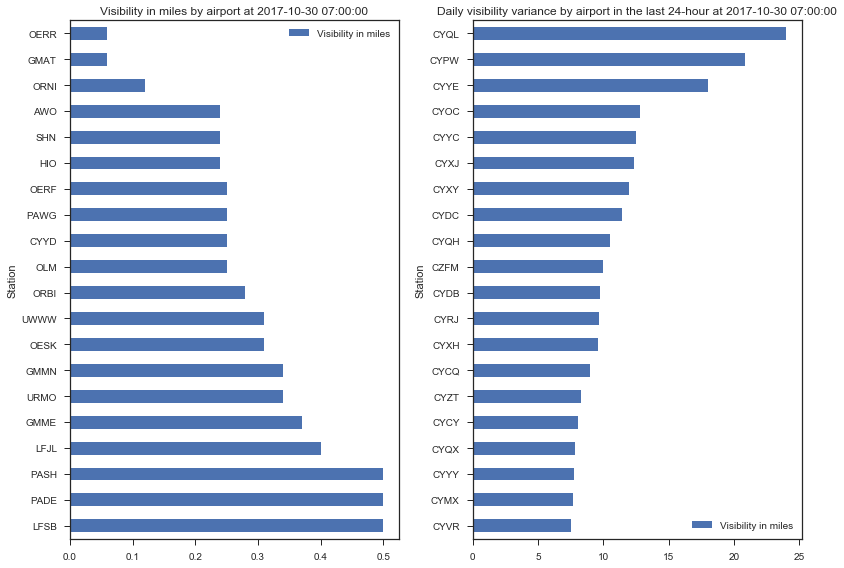

In [14]:
# Find airport with lowest visibility
df_weather['Time_string'] = df_weather['Date'].apply(lambda t: str(t))
df = df_weather[df_weather['Time_string'].str.endswith('2017-10-30 07:00:00')]
df = df[['Station', 'Visibility in miles']]
df = df[~pd.isnull(df['Visibility in miles'])]
df_min = df
df = df.sort_values('Visibility in miles', ascending=False).tail(20).reset_index(drop=True)

df1 = airports.merge(df, left_on='IATA', right_on='Station', how='left')
df2 = df1.merge(df, left_on='ICAO', right_on='Station', how='left')
df3 = df2[(~pd.isnull(df2['Visibility in miles_x'])) | (~pd.isnull(df2['Visibility in miles_y']))].reset_index(drop=True)

df3[['Visibility in miles_x', 'Visibility in miles_y']] = df3[['Visibility in miles_x', 'Visibility in miles_y']].fillna(value=0)
df3[['Station_x', 'Station_y']] = df3[['Station_x', 'Station_y']].fillna(value='')
df3['Visibility in miles'] = df3['Visibility in miles_x'] + df3['Visibility in miles_y']
df3['Station'] = df3['Station_x'] + df3['Station_y']
df3 = df3.sort_values('Visibility in miles', ascending=False).reset_index(drop=True)

df_min_20 = df3

# Find airport with greatest variance in visibility
df = df_weather[df_weather['Time_string'].str.endswith(':00:00')]
df = df[(df['Time_string'] >= '2017-10-29 07:00:00') & (df['Time_string'] <= '2017-10-30 07:00:00')]
df = df[['Station', 'Visibility in miles']]
df = df.groupby('Station').agg(lambda g: np.std(g['Visibility in miles'])).reset_index()
df = df[~pd.isnull(df['Visibility in miles'])]
df_var = df
df = df.sort_values('Visibility in miles', ascending=False).head(20).reset_index(drop=True)

df1 = airports.merge(df, left_on='IATA', right_on='Station', how='left')
df2 = df1.merge(df, left_on='ICAO', right_on='Station', how='left')
df3 = df2[(~pd.isnull(df2['Visibility in miles_x'])) | (~pd.isnull(df2['Visibility in miles_y']))].reset_index(drop=True)

df3[['Visibility in miles_x', 'Visibility in miles_y']] = df3[['Visibility in miles_x', 'Visibility in miles_y']].fillna(value=0)
df3[['Station_x', 'Station_y']] = df3[['Station_x', 'Station_y']].fillna(value='')
df3['Visibility in miles'] = df3['Visibility in miles_x'] + df3['Visibility in miles_y']
df3['Station'] = df3['Station_x'] + df3['Station_y']
df3 = df3.sort_values('Visibility in miles', ascending=True).reset_index(drop=True)

df_var_20 = df3

# Plot
f, axes = plt.subplots(1, 2, figsize=(12,8))
df_min_20.plot(ax=axes[0], x='Station', y = 'Visibility in miles', kind='barh',\
    title='Visibility in miles by airport at 2017-10-30 07:00:00')
df_var_20.plot(ax=axes[1], x='Station', y = 'Visibility in miles', kind='barh',\
    title='Daily visibility variance by airport in the last 24-hour at 2017-10-30 07:00:00')
plt.tight_layout()

# Figure 2 - Routes of visibility concerns

Plot out routes that depart/arrive at the above airports on the world map. RED is for low visibility airports and BLUE is for high-variance airports. The circle size indicates the severity.

In [22]:

from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm

# Simple plot
import folium
m = folium.Map(location=[30,-30], zoom_start=2.3)

for idx in range(0, 5):
    i = - idx - 1
    folium.Circle(location=[df_min_20.iloc[i]['Latitude'], df_min_20.iloc[i]['Longitude']],
        popup=df_min_20.iloc[i]['Station'] + ' ' + df_min_20.iloc[i]['Name'],
        radius=1/df_min_20.iloc[i]['Visibility in miles']*30000,
        color='crimson',
        fill=True, fill_color='crimson'
    ).add_to(m)

for idx in range(0, 5):
    i = - idx - 1
    folium.Circle(location=[df_var_20.iloc[i]['Latitude'], df_var_20.iloc[i]['Longitude']],
        popup=df_var_20.iloc[i]['Station']+' '+df_var_20.iloc[i]['Name'],
        radius=df_var_20.iloc[i]['Visibility in miles']*10000,
        color='blue',
        fill=True, fill_color='blue'
    ).add_to(m)

routes = pd.read_csv('routes.dat', header=None)
routes.columns = ['Airline', 'Airline_ID', 'Source_airport', 'Source_airport_ID',\
    'Destination_airport', 'Destination_airport_ID', 'Codeshare', 'Stops', 'Equipment']
airport_min_iata = df_min_20.tail(5).IATA.tolist()
airport_var_iata = df_var_20.tail(5).IATA.tolist()
routes_1 = routes[routes['Source_airport'].isin(airport_min_iata)]
routes_2 = routes[routes['Source_airport'].isin(airport_var_iata)]

def get_airport_coor(airport):
    df_x = airports[airports.IATA==airport].reset_index()
    lat = df_x['Latitude'][0]
    long = df_x['Longitude'][0]
    return (lat, long)

for i in range(0, len(routes_2)):
    dep = routes_2.iloc[i].Source_airport
    arr = routes_2.iloc[i].Destination_airport
    if (len(airports[airports.IATA==dep]) > 0) & (len(airports[airports.IATA==arr]) > 0):
        folium.PolyLine(locations=[get_airport_coor(dep),\
                                    get_airport_coor(arr)],
            weight=1, color='blue'
        ).add_to(m)
        
for i in range(0, len(routes_1)):
    dep = routes_1.iloc[i].Source_airport
    arr = routes_1.iloc[i].Destination_airport
    if (len(airports[airports.IATA==dep]) > 0) & (len(airports[airports.IATA==arr]) > 0):
        folium.PolyLine(locations=[get_airport_coor(dep), get_airport_coor(arr)],
            weight=2, color='crimson'
        ).add_to(m)

m.save('folium_map1.html')
m